In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv("ga4.csv")
df.head()
df.columns

Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird'],
      dtype='object')

In [44]:
X = df.drop(columns=[' _rain',' _conds',' _precipm',' _snow', ' _thunder',' _tornado','datetime_utc'])
y = df[' _rain']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
X_train


,_dewptm,_fog,_hail,_heatindexm,_hum,_pressurem,_tempm,_vism,_wdird
12,11,0.33,0.5,24.4,60,1010,19,1.50,270
1,10,0.20,0.1,24.5,32,1009,28,3.00,260
13,10,0.00,0.0,28.4,88,1012,12,1.50,100
5,12,0.11,0.2,28.8,56,1011,21,0.70,240
2,11,0.10,0.2,21.5,44,1003,24,2.00,240
11,12,0.25,0.1,28.8,64,1009,19,0.14,260
20,21,0.00,0.0,30.2,66,1003,28,3.00,234
3,10,0.21,0.1,23.5,41,1010,24,2.00,230
4,11,0.44,0.2,27.5,47,1011,23,1.20,280
18,19,0.00,0.0,32.5,94,1008,20,3.50,290


In [117]:
num_objectives = 2  
creator.create("FitnessMulti", base.Fitness, weights=tuple(1.0 for _ in range(num_objectives)))
creator.create("Individual", list, fitness=creator.FitnessMulti)
hall_of_fame = tools.HallOfFame(5)  # Store the best individual

C:\Users\ADMIN\anaconda3\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\ADMIN\anaconda3\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [118]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.choice, [0, 1])  # Binary genes (0 or 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)  # Two-point crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)  # Bit flip mutation
toolbox.register("select", tools.selTournament, tournsize=3)  # Tournament selection
toolbox.register("evaluate", lambda ind: fitness_function(ind, X_train, X_test, y_train, y_test))

In [119]:
def fitness_function(solution, X_train, X_test, y_train, y_test):
    selected_features = [col for col, selected in zip(X_train.columns, solution) if selected]

    if len(selected_features) == 0:
        return (0.0, 0.0)  # Return a tuple with multiple values for the fitness

    #  (Random Forest Classifier in this case)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train[selected_features], y_train)

    # Predict on the test set
    y_pred = model.predict(X_test[selected_features])

    # Calculate the fitness (maximize accuracy and minimize the number of selected features)
    accuracy_fitness = accuracy_score(y_test, y_pred)
    num_features_fitness = len(selected_features)

    return (accuracy_fitness, num_features_fitness)  # Return a tuple with multiple values for the fitnes

In [120]:
population_size = 100
crossover_probability = 0.7
mutation_probability = 0.2
number_of_generations = 10

# Create the population
population = toolbox.population(n=population_size)

# Run the genetic algorithm
algorithms.eaMuPlusLambda(population, toolbox, mu=10, lambda_=50, cxpb=crossover_probability,
                          mutpb=mutation_probability, ngen=number_of_generations,
                          stats=None, halloffame=hall_of_fame, verbose=True)

# Extract information from the hall of fame
fitness_values = [ind.fitness.values for ind in hall_of_fame]
num_selected_features = [sum(ind) for ind in hall_of_fame]

gen	nevals
0  	100   
1  	48    
2  	42    
3  	44    
4  	44    
5  	49    
6  	47    
7  	44    
8  	47    
9  	47    
10 	46    


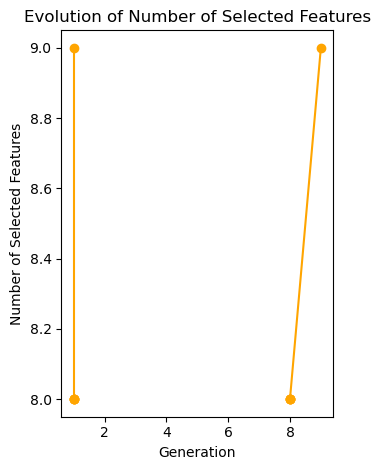

In [121]:
plt.subplot(1, 2, 2)
plt.plot(fitness_values[:],num_selected_features[:], marker='o', color='orange')
plt.title('Evolution of Number of Selected Features')
plt.xlabel('Generation')
plt.ylabel('Number of Selected Features')

plt.tight_layout()
plt.show()

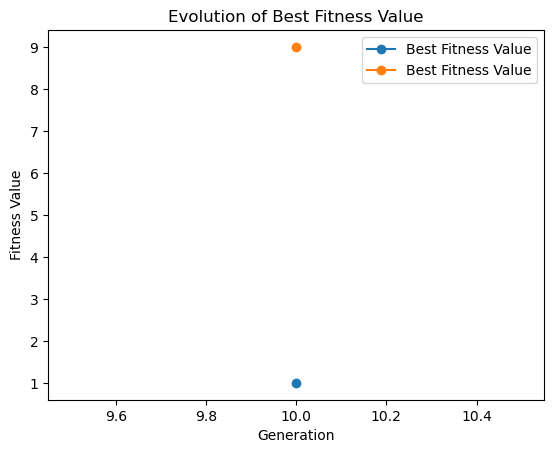

In [103]:
plt.plot(number_of_generations, fitness_values[:], marker='o', label='Best Fitness Value')

plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.title('Evolution of Best Fitness Value')
plt.legend()
plt.show()


In [105]:
for generation, ind in enumerate(hall_of_fame):
    selected_features_indices = [i for i, value in enumerate(ind) if value == 1]
    selected_features_names = X.columns[selected_features_indices]
    print(f"Generation {generation}: Selected Features - {selected_features_indices} ({selected_features_names.tolist()})")


Generation 0: Selected Features - [0, 1, 2, 3, 4, 5, 6, 7, 8] ([' _dewptm', ' _fog', ' _hail', ' _heatindexm', ' _hum', ' _pressurem', ' _tempm', ' _vism', ' _wdird'])
